In [4]:
import fasttext
model = fasttext.load_model('./util/cc.en.300.bin')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import json

from tqdm import tqdm

In [6]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [7]:
pd.set_option("display.max_rows", 250)

In [8]:
df = pd.read_csv("./mcd_result/base_mcd.csv")

df['aspect'] = df['aspect'].apply(lambda x: x.split(", "))
df['token_sentence'] = df['token_sentence'].apply(lambda x: x.split('.\n'))
# df['topic_keys'] = df['topic_keys'].apply(lambda x: x.split(", "))
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     100 non-null    int64 
 1   review          100 non-null    object
 2   summarize       100 non-null    object
 3   aspect          100 non-null    object
 4   token_sentence  100 non-null    object
 5   token_lemma     100 non-null    object
 6   rating          100 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 5.6+ KB
None


,reviewer_id,review,summarize,aspect,token_sentence,token_lemma,rating
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food...,"[normal transaction, clear substance, someone ...",[Why does it look like someone spit on my food...,why do it look like someone spit on my food.\n...,1
1,2,It'd McDonalds. It is what it is as far as the...,The staff at McDonalds are always friendly an...,"[atmosphere, staff, food, mcdonalds]",[The staff at McDonalds are always friendly an...,the staff at mcdonalds be always friendly and ...,4
2,3,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...,"[mobile order, line, refund, money]","[Never got the refund in the app., Made a mobi...",never get the refund in the app ..\nmake a mob...,1
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer ...,"[chicken sandwich, customer service, customer,...",[Crispy chicken sandwich was customer service...,crispy chicken sandwich be customer service be...,5
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ...","[order, large meal, english, close attention, ...","[I repeat my order 3 times in the drive thru, ...",i repeat my order 3 time in the drive thru.\ni...,1


In [9]:
df_an = df[['reviewer_id', 'aspect']].copy()
df_an.head()

,reviewer_id,aspect
0,1,"[normal transaction, clear substance, someone ..."
1,2,"[atmosphere, staff, food, mcdonalds]"
2,3,"[mobile order, line, refund, money]"
3,4,"[chicken sandwich, customer service, customer,..."
4,5,"[order, large meal, english, close attention, ..."


# Coding Process

In [10]:
# map_categorize = {
#     0: 'order and food',
#     1: 'service and time',
#     2: 'order and food',
#     3: 'order and food',
#     4: 'service and time',
#     5: 'order and food',
#     6: 'service and time',
# }

# df['category'] = df['topic'].apply(lambda x: map_categorize[x])

# print(df.info())
# df.head()

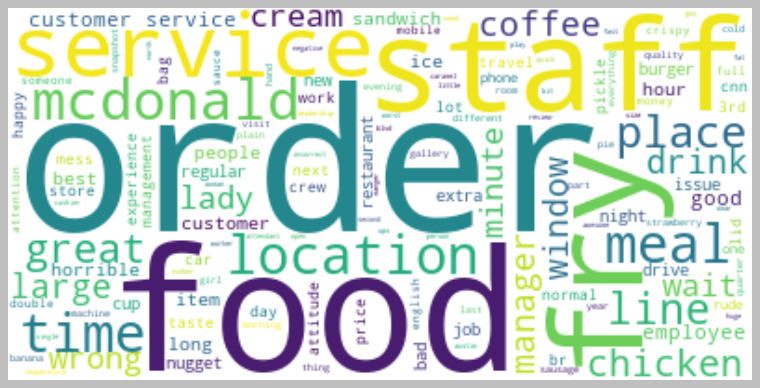

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
aspects = df_an['aspect'].values
for i in range(df_an.shape[0]):
    text = text + " " + " ".join(list(aspects[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
words_count = {}

words = text.split()

for word in words:
    word = word.lower()
    if word in words_count:
        words_count[word] += 1
    else:
        words_count[word] = 1
        
# words_count = dict(
#                 sorted(words_count.items(),
#                        key=lambda x: x[1],
#                        reverse=True))

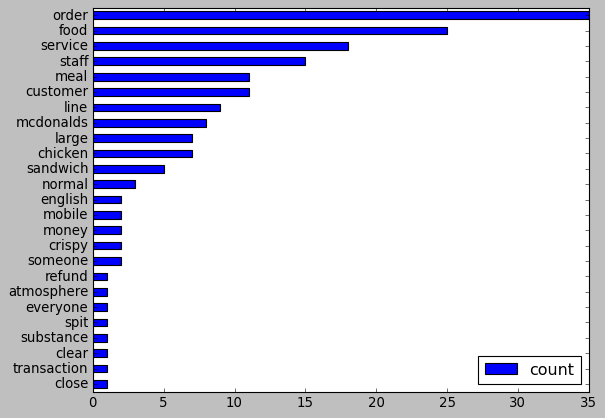

In [13]:
df_word = pd.DataFrame(data=words_count.values(),
                       index=words_count.keys(), 
                       columns=['count'])

df_word.head(25).sort_values(by='count', ascending=True).plot(kind='barh')
plt.show()

2.0


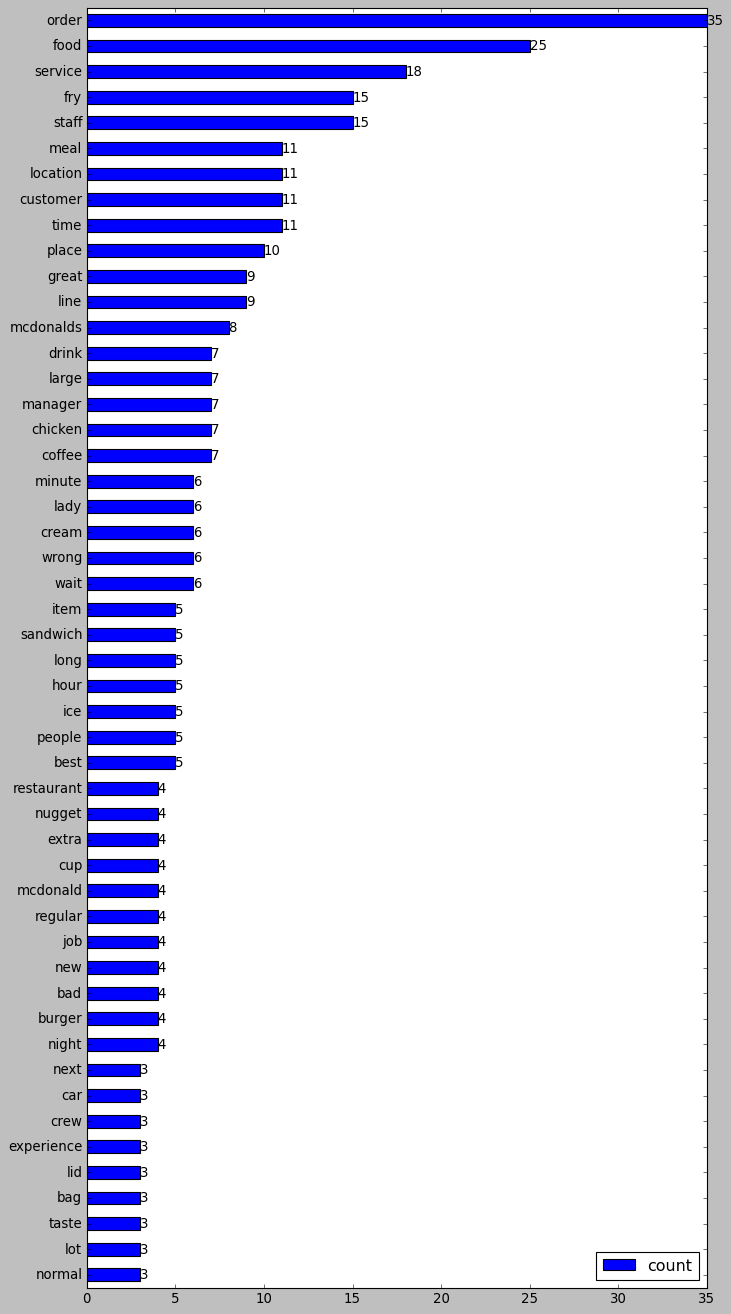

In [14]:
# Show 75% words

threshold = df_word.quantile(q=0.75).iloc[0]
# threshold = 0.25 * df_word.max().iloc[0]
# threshold = df_word.mean().iloc[0]
print(threshold)

df_plot = df_word[df_word['count'] > threshold]\
        .head(50)

ax = df_plot\
        .sort_values(by='count', ascending=True)\
        .plot(kind='barh', figsize=(10, 20))

for container in ax.containers:
    ax.bar_label(container)

plt.show()

## A. First Cycle

In [15]:
list_first_cycle = list(df_word[df_word['count'] > threshold].index)
print(len(list_first_cycle))

# Additional filter
list_first_cycle = [word for word in list_first_cycle if len(word) >= 3]

def first_cycle(x):
    global list_first_cycle
        
    set1 = set(" ".join(x).split(" "))
    set2 = set(list_first_cycle)
    
    temp = set1 & set2
    
    if len(temp) != len(set1):
        temp.add("other")
    return temp

def get_other(x):
    global list_first_cycle
    
    set1 = set(" ".join(x).split(" "))
    set2 = set(list_first_cycle)
    
    temp = set1.difference(set2)
    
    return temp

def get_residu(x):
    texts = x['residu']
    array = x['aspect']

    temp = []
    print(texts)
    for text in texts:
        pattern = re.compile(rf"{text}")
        
        result = [element for element in array if pattern.search(element)]
        temp = temp + result

    return set(temp)



tqdm.pandas()
df_an['first_cycle'] = df_an['aspect'].progress_apply(lambda x: first_cycle(x))

df_an['residu'] = df_an['aspect'].progress_apply(lambda x: get_other(x))

df_an['residu'] = [get_residu(x[-1]) for x in df_an.iterrows()]

df_an = df_an.explode('first_cycle').reset_index(drop=True)
df_an

70


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33177.54it/s]

{'everyone', 'transaction', 'someone', 'clear', 'spit', 'substance'}
{'atmosphere'}
{'refund', 'money', 'mobile'}
{'crispy'}
{'close', 'double', 'attention', 'english', 'filet'}
{'covid', 'door', 'dash'}
{'home', 'cooky', 'simple', 'hamburg'}
{'w', 'full'}
{'hard', 'piece', 'sauce'}
{'mcds', 'quality'}
{'effort', 'globe', 'series', 'golden'}
{'task', 'husband'}
{'morning', 'different'}
{'condiment', 'thing', 'breakfast', 'big', 'full', '#', 'hot', 'cake'}
{'poor', 'girl', 'part', 'hand'}
{'table'}
{'pie', 'strawberry', 'cinnabun', 'substitute', 'apple'}
{'boy'}
{'straight', 'disappointed', 'smoothy', 'strawberry', 'hash', 'fact', 'banana', 'smoothie', 'water', 'smh'}
{'perpetual', 'learning', 'lobby'}
{'more', 'name', 'other', 'take', 'rush', 'taker'}
{'evening', 'year', 'morning', 'past'}
{'caffeine'}
{'microwave', 'cold'}
{'card'}
{'broken', 'machine', 'reply'}
{'clean', 'everything'}
{'week', 'travel', 'visit', 'snapshot', 'gallery', 'photo', 'shot', 'cnn', 'weekly', 'ireporter', 'f

,reviewer_id,aspect,first_cycle,residu
0,1,"[normal transaction, clear substance, someone ...",other,"{someone spit, everyone, clear substance, norm..."
1,1,"[normal transaction, clear substance, someone ...",normal,"{someone spit, everyone, clear substance, norm..."
2,2,"[atmosphere, staff, food, mcdonalds]",mcdonalds,{atmosphere}
3,2,"[atmosphere, staff, food, mcdonalds]",food,{atmosphere}
4,2,"[atmosphere, staff, food, mcdonalds]",other,{atmosphere}
...,...,...,...,...
447,99,"[allways, best fry, ice cream]",fry,{allways}
448,100,"[order, people, english, mcdonalds]",mcdonalds,{english}
449,100,"[order, people, english, mcdonalds]",people,{english}
450,100,"[order, people, english, mcdonalds]",other,{english}


## B. Second Cycle

In [16]:
map_second_code = {'situation': ['normal', 'line', 'large', 'long', 'regular', 'people', 'wait',
                                 'night', 'hour', 'wrong', 'minute', 'mess', 'day'], 
                   'place': ['mcdonald', 'mcdonalds', 'location', 'place', 'car', 'restaurant', 'window', 'store', 'drive',],
                   'emotion': ['great', 'best', 'bad', 'great', 'horrible', 'good', 'happy', 'rude',], 
                   'service': ['staff', 'customer', 'service', 'location', 'regular', 'time', 'lady', 'experience', 'crew',
                               'manager', 'employee', 'price', 'management', 'attitude', 'work', 'issue'],
                   'food': ['food', 'order', 'chicken', 'sandwich', 'meal', 'fry',
                            'nugget', 'item', 'cream', 'pickle', 'strawberry', 'burger'],
                   'drink': ['coffee', 'cup', 'item', 'drink', 'cream', 'strawberry', 'ice'] 
                  }

def second_cycle(x):
    temp = set()
    for key in map_second_code.keys():
        if x in map_second_code[key]:
            temp.add(key)
#     if len(temp) == 0:
#         temp.add('other')
        
    return temp


tqdm.pandas()
df_an['second_cycle'] = df_an['first_cycle'].progress_apply(lambda x: second_cycle(x))
# # EXPERIMENT
experiment = df_an[['reviewer_id', 'aspect', 'residu', 'first_cycle', 'second_cycle']].copy()


100%|████████████████████████████████████████████████████████████████████████████| 452/452 [00:00<00:00, 204931.94it/s]


In [17]:
# Extract residu

def extract_residu(x):
    global map_second_code
    
    residu = x['residu']
    first_cycle = x['first_cycle']
    second_keys = list(map_second_code.keys())
    temp = []
    
    if first_cycle != 'other':
        return set()
    
    for s in residu:
        result = util.get_nearest_word(s, second_keys,
                                       model, threshold=.35)
        
        if result:
            temp.append(result)
    return set(temp)

def merge_residu(x):
    set1 = x['second_cycle']
    set2 = x['extract_residu']
    
    result = set1.union(set2)
    
    if len(result) == 0:
        return set(['other'])
    return set1.union(set2)


df_an['extract_residu'] = [extract_residu(x[-1]) for x in df_an.iterrows()]
df_an['second_cycle'] = [merge_residu(x[-1]) for x in df_an.iterrows()]


df_an = df_an.explode('second_cycle').reset_index(drop=True).drop('extract_residu', axis=1)

df_an

,reviewer_id,aspect,first_cycle,residu,second_cycle
0,1,"[normal transaction, clear substance, someone ...",other,"{someone spit, everyone, clear substance, norm...",drink
1,1,"[normal transaction, clear substance, someone ...",normal,"{someone spit, everyone, clear substance, norm...",situation
2,2,"[atmosphere, staff, food, mcdonalds]",mcdonalds,{atmosphere},place
3,2,"[atmosphere, staff, food, mcdonalds]",food,{atmosphere},food
4,2,"[atmosphere, staff, food, mcdonalds]",other,{atmosphere},place
...,...,...,...,...,...
491,99,"[allways, best fry, ice cream]",fry,{allways},food
492,100,"[order, people, english, mcdonalds]",mcdonalds,{english},place
493,100,"[order, people, english, mcdonalds]",people,{english},situation
494,100,"[order, people, english, mcdonalds]",other,{english},other


In [18]:
# Store residu data

residu_frame = df_an.groupby('reviewer_id')['residu']\
                .apply(lambda x: set().union(*x))\
                .reset_index()

residu_frame['residu'] = residu_frame['residu'].apply(lambda x: ", ".join(list(x)))

In [19]:
result = df_an[['reviewer_id', 'first_cycle', 'second_cycle']]\
            .copy()\
            .reset_index()\
            .rename(columns={'index': 'node_id'})

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   node_id       496 non-null    int64 
 1   reviewer_id   496 non-null    int64 
 2   first_cycle   496 non-null    object
 3   second_cycle  496 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.6+ KB
None


,node_id,reviewer_id,first_cycle,second_cycle
0,0,1,other,drink
1,1,1,normal,situation
2,2,2,mcdonalds,place
3,3,2,food,food
4,4,2,other,place


## C. Categorizing

In [20]:
map_categorizing = {
    'sentiment': ['emotion'],
    'place and service': ['service', 'situation', 'place'],
    'food and drink': ['food', 'drink'],
}

def final_categorizing(x):
    for key in map_categorizing.keys():
        if x in map_categorizing[key]:
            return key
    return "other"

tqdm.pandas()
result['category'] = result['second_cycle'].progress_apply(lambda x: final_categorizing(x))

100%|████████████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 760093.09it/s]


In [21]:
result

,node_id,reviewer_id,first_cycle,second_cycle,category
0,0,1,other,drink,food and drink
1,1,1,normal,situation,place and service
2,2,2,mcdonalds,place,place and service
3,3,2,food,food,food and drink
4,4,2,other,place,place and service
...,...,...,...,...,...
491,491,99,fry,food,food and drink
492,492,100,mcdonalds,place,place and service
493,493,100,people,situation,place and service
494,494,100,other,other,other


# Linking Nodes

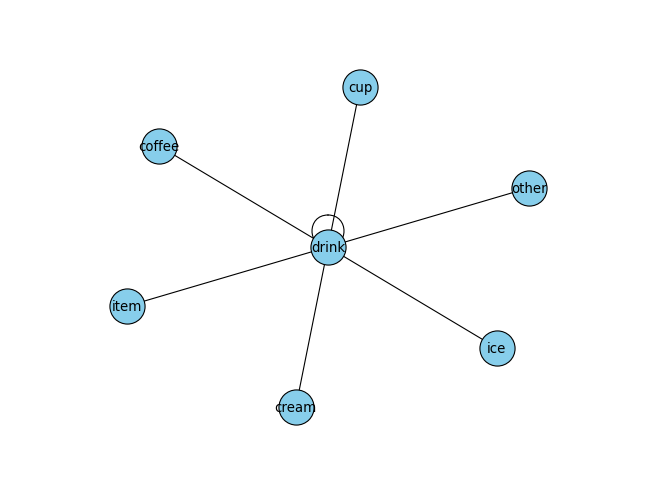

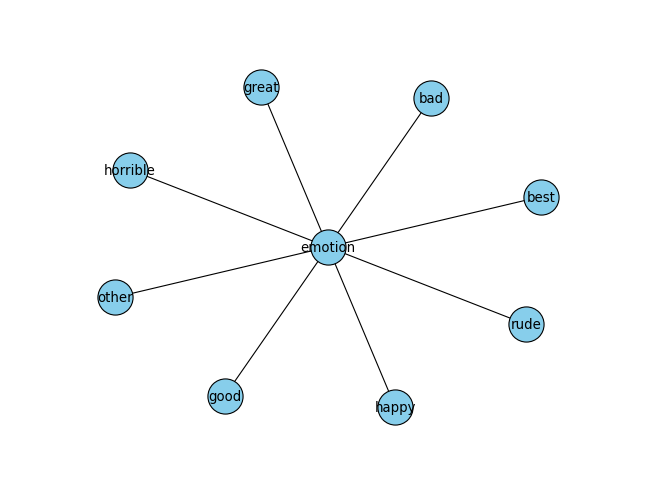

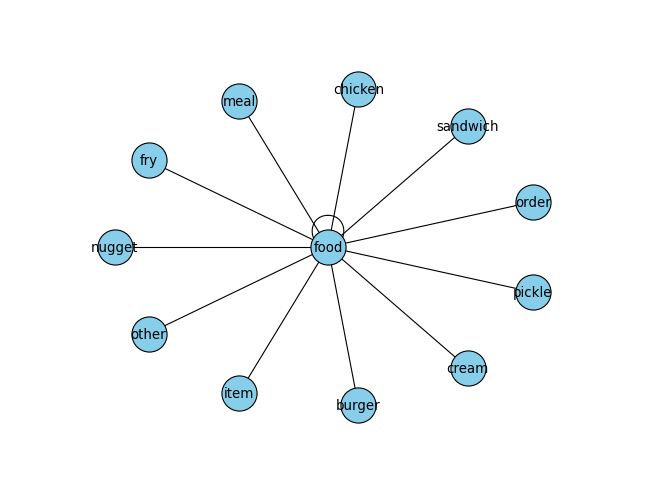

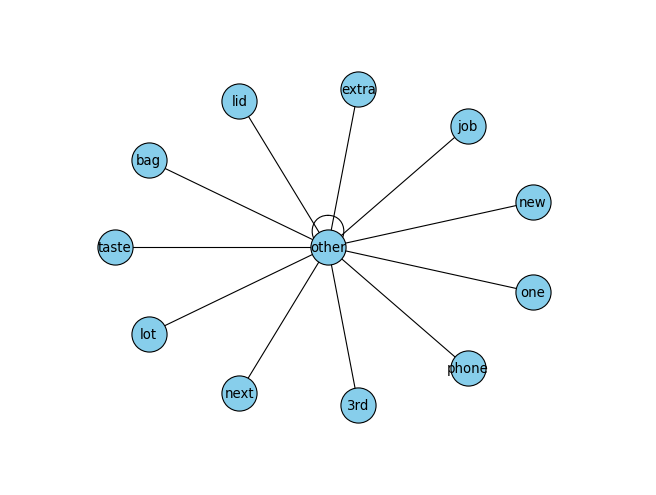

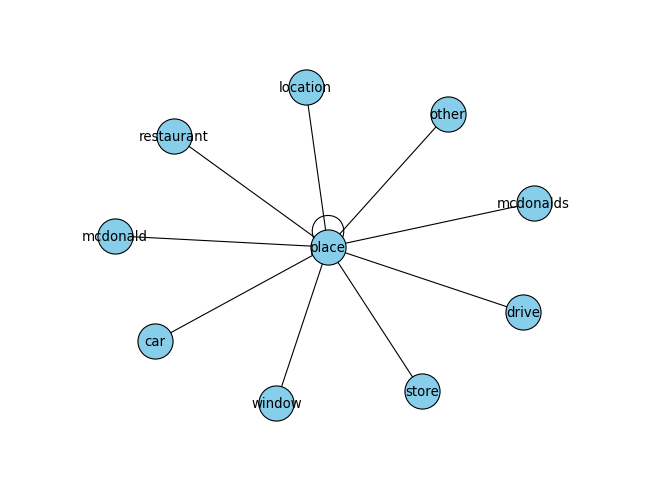

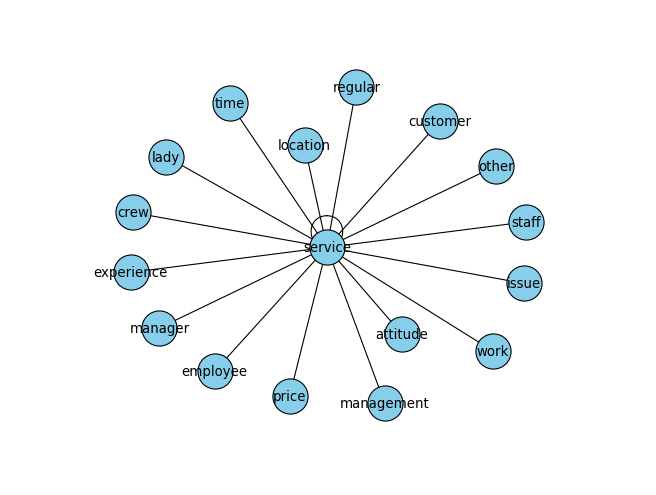

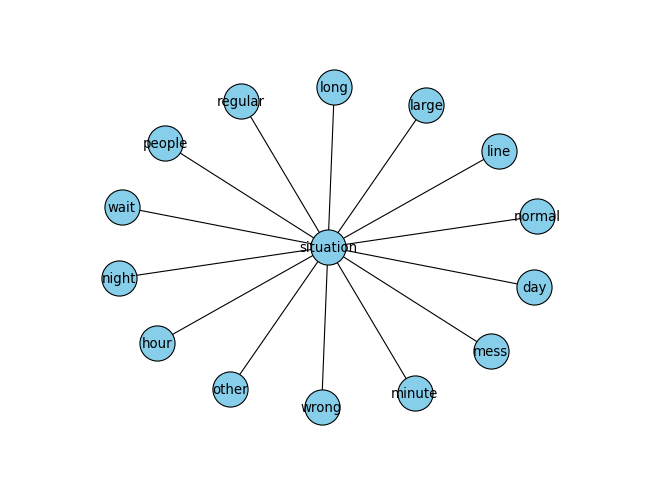

In [22]:
import networkx as nx

for cat in np.unique(df_an['second_cycle'].values):
    df_plot = df_an[df_an['second_cycle'] == cat]
    G = nx.from_pandas_edgelist(df_plot, 'first_cycle', 'second_cycle')
    nx.draw_kamada_kawai(G, with_labels=True, node_color='skyblue', node_size=1000)
    plt.show()

# Add Residu to Data Base (Update Base)

In [23]:
df = df.merge(residu_frame, on='reviewer_id', how='left')

df['aspect'] = df['aspect'].apply(lambda x: ", ".join(list(x)))
df['token_sentence'] = df['token_sentence'].apply(lambda x: ", ".join(list(x)))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     100 non-null    int64 
 1   review          100 non-null    object
 2   summarize       100 non-null    object
 3   aspect          100 non-null    object
 4   token_sentence  100 non-null    object
 5   token_lemma     100 non-null    object
 6   rating          100 non-null    int64 
 7   residu          100 non-null    object
dtypes: int64(2), object(6)
memory usage: 6.4+ KB
None


,reviewer_id,review,summarize,aspect,token_sentence,token_lemma,rating,residu
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food...,"normal transaction, clear substance, someone s...","Why does it look like someone spit on my food,...",why do it look like someone spit on my food.\n...,1,"everyone, clear substance, someone spit, norma..."
1,2,It'd McDonalds. It is what it is as far as the...,The staff at McDonalds are always friendly an...,"atmosphere, staff, food, mcdonalds",The staff at McDonalds are always friendly and...,the staff at mcdonalds be always friendly and ...,4,atmosphere
2,3,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...,"mobile order, line, refund, money","Never got the refund in the app., Made a mobil...",never get the refund in the app ..\nmake a mob...,1,"refund, money, mobile order"
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer ...,"chicken sandwich, customer service, customer, ...",Crispy chicken sandwich was customer service ...,crispy chicken sandwich be customer service be...,5,crispy chicken
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ...","order, large meal, english, close attention, l...","I repeat my order 3 times in the drive thru, i...",i repeat my order 3 time in the drive thru.\ni...,1,"english, close attention, double filet"


# Save Important Files

In [24]:
result.to_csv("./mcd_result/nodes_mcd.csv", index=False)

In [25]:
df.to_csv("./mcd_result/base_mcd_v1.csv", index=False)

In [26]:
with open("./mcd_result/map_second_mcd.json", 'w') as file:
    json.dump(map_second_code, file)
    
with open("./mcd_result/map_category_mcd.json", "w") as file:
    json.dump(map_categorizing, file)
    
with open("./mcd_result/list_first_cycle_mcd.json", "w") as file:
    json.dump(list_first_cycle, file)